In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from torch import nn
import torch
from xgboost import XGBRegressor
from LSTMFeatureExtractor import LSTMFeatureExtractor

In [180]:
df = pd.read_excel("../dataset/ETTm2.xlsx")
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

In [181]:
print ("Điền khuyết điểm bằng nội suy theo thời gian . . .")
df = df.interpolate(method='time')

Điền khuyết điểm bằng nội suy theo thời gian . . .


In [182]:
print ("Chuan hoa du lieu . . .")
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaler_df = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)  
print ("Tien xu ly du lieu hoan tat")

Chuan hoa du lieu . . .
Tien xu ly du lieu hoan tat


In [183]:
# - - -2. Lua chon dac trung - - -
selected_colums = [col for col in scaler_df.columns if col != 'OT'] + ['OT']
reduced_df = scaler_df[selected_colums].astype(np.float32)
print ("So dac trung (khong tinh 'OT'): ", len(selected_colums) - 1)

So dac trung (khong tinh 'OT'):  6


In [184]:
# - - - 3. Tao chuoi du lieu thoi gian Supervised - - - (Du bao mot buoc)
def create_supervited_data(data, targer_column = 'OT', window_size = 96):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data.iloc[i-window_size:i].values)
        y.append(data.iloc[i][targer_column])
    return np.array(X), np.array(y)

In [185]:
X_single_step, y_single_step = create_supervited_data(reduced_df, window_size=96)
print("Shape of X (single step):", X_single_step.shape)
print("Shape of y (single step):", y_single_step.shape)

Shape of X (single step): (69584, 96, 7)
Shape of y (single step): (69584,)


In [186]:
# ----- 4. Trich xuat dac trung bang LSTM -----
lstm_extractor = LSTMFeatureExtractor(input_size=X_single_step.shape[2], hidden_size=64, num_layers=2)
lstm_extractor.eval()

LSTMFeatureExtractor(
  (lstm): LSTM(7, 64, num_layers=2, batch_first=True)
)

In [187]:
with torch.no_grad():
    features_single_step = lstm_extractor(torch.tensor(X_single_step, dtype=torch.float32)).numpy()
print("Shape of features:", features_single_step.shape)

Shape of features: (69584, 64)


In [188]:
# --- 5. Huấn luyện và Đánh giá XGBoost (Dự báo một bước) ---
xgb_model_single_step = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.01, random_state=42)
xgb_model_single_step.fit(features_single_step, y_single_step)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [189]:
y_pred_single_step = xgb_model_single_step.predict(features_single_step)
mse_single_step = mean_squared_error(y_single_step, y_pred_single_step)
mae_single_step = mean_absolute_error(y_single_step, y_pred_single_step)
print(f"MSE: {mse_single_step:.4f}")
print(f"MAE: {mae_single_step:.4f}")

MSE: 0.1578
MAE: 0.3300


In [190]:
# --- 6. Tạo Dữ liệu Dự báo Đa bước ---
print("\n--- 6. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo đa bước) ---")
def create_multistep_supervised_data(data, target_column='OT', window_size=96, horizon=12):
    X, y = [], []
    target_series = data[target_column].values
    for i in range(window_size, len(data) - horizon):
        X.append(data.iloc[i-window_size:i].values)
        y.append(target_series[i:i+horizon])
    return np.array(X), np.array(y)


--- 6. Tạo Dữ liệu Chuỗi thời gian Supervised (Dự báo đa bước) ---


In [191]:
X_96, y_96 = create_multistep_supervised_data(reduced_df, window_size=96, horizon=96)
X_192, y_192 = create_multistep_supervised_data(reduced_df, window_size=96, horizon=192)
X_336, y_336 = create_multistep_supervised_data(reduced_df, window_size=96, horizon=336)
X_720, y_720 = create_multistep_supervised_data(reduced_df, window_size=96, horizon=720)
print("Đã tạo dữ liệu cho các horizon 96, 192, 336, 720.")

Đã tạo dữ liệu cho các horizon 96, 192, 336, 720.


In [192]:
# --- 7. Trích xuất Đặc trưng và Huấn luyện XGBoost Đa bước ---
print("\n--- 7. Trích xuất Đặc trưng và Huấn luyện XGBoost cho Dự báo Đa bước ---")
def extract_lstm_features(X, input_size, model=None):
    if model is None:
        model = LSTMFeatureExtractor(input_size)
    model.eval()
    with torch.no_grad():
        return model(torch.tensor(X, dtype=torch.float32)).numpy()

features_96 = extract_lstm_features(X_96, input_size=X_96.shape[2], model=lstm_extractor)
features_192 = extract_lstm_features(X_192, input_size=X_192.shape[2], model=lstm_extractor)
features_336 = extract_lstm_features(X_336, input_size=X_336.shape[2], model=lstm_extractor)
features_720 = extract_lstm_features(X_720, input_size=X_720.shape[2], model=lstm_extractor)


--- 7. Trích xuất Đặc trưng và Huấn luyện XGBoost cho Dự báo Đa bước ---


In [193]:
def train_xgboost_multioutput_full_data(X, y):
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, max_depth = 5, learning_rate=0.01, random_state=42))
    model.fit(X, y)
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    return model, mse, mae

model_96, mse_96, mae_96 = train_xgboost_multioutput_full_data(features_96, y_96)
model_192, mse_192, mae_192 = train_xgboost_multioutput_full_data(features_192, y_192)
model_336, mse_336, mae_336 = train_xgboost_multioutput_full_data(features_336, y_336)
model_720, mse_720, mae_720 = train_xgboost_multioutput_full_data(features_720, y_720)

print("\n--- Đánh giá Dự báo Đa bước (trên toàn bộ dữ liệu) ---")
print(f"Horizon 96 - MSE: {mse_96:.4f}, MAE: {mae_96:.4f}")
print(f"Horizon 192 - MSE: {mse_192:.4f}, MAE: {mae_192:.4f}")
print(f"Horizon 336 - MSE: {mse_336:.4f}, MAE: {mae_336:.4f}")
print(f"Horizon 720 - MSE: {mse_720:.4f}, MAE: {mae_720:.4f}")



--- Đánh giá Dự báo Đa bước (trên toàn bộ dữ liệu) ---
Horizon 96 - MSE: 0.2755, MAE: 0.4236
Horizon 192 - MSE: 0.2985, MAE: 0.4414
Horizon 336 - MSE: 0.3214, MAE: 0.4586
Horizon 720 - MSE: 0.3456, MAE: 0.4768


In [194]:
# --- Tổng MSE và MAE của các horizon ---
total_mse = (mse_96 + mse_192 + mse_336 + mse_720)/4
total_mae = (mae_96 + mae_192 + mae_336 + mae_720)/4
print(f"\nTổng MSE các horizon: {total_mse:.4f}")
print(f"Tổng MAE các horizon: {total_mae:.4f}")



Tổng MSE các horizon: 0.3103
Tổng MAE các horizon: 0.4501



--- 8. Vẽ biểu đồ Dự báo Một bước ---


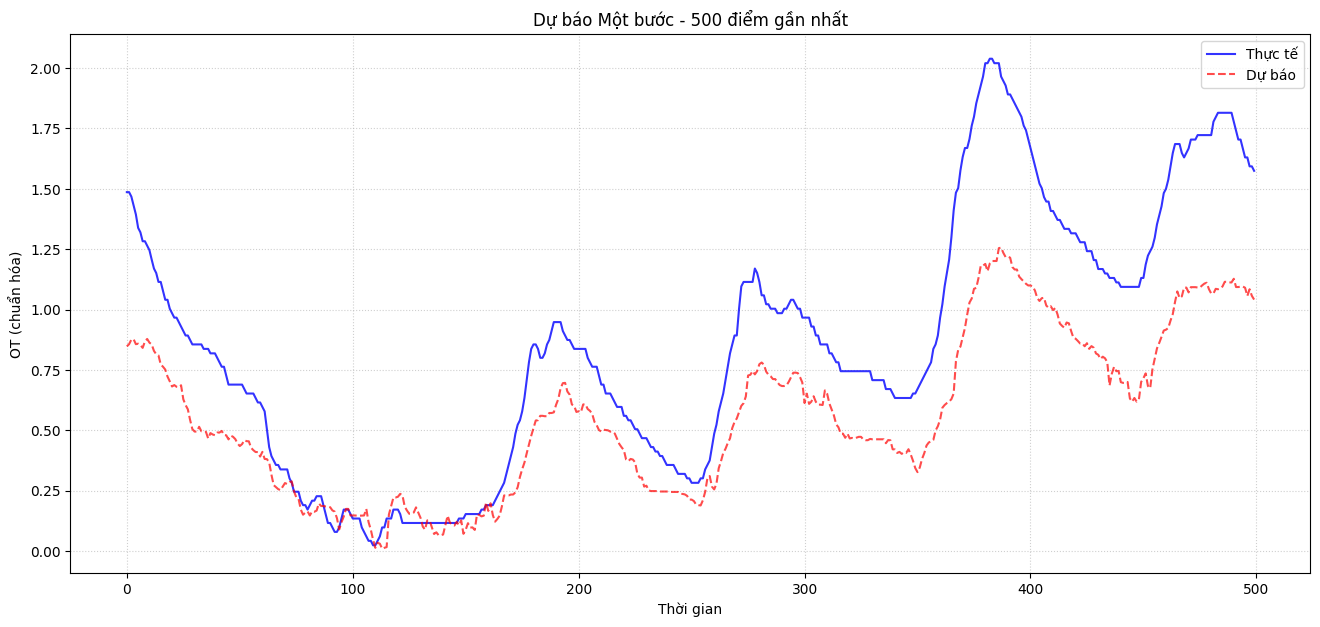

In [195]:
# --- 8. Vẽ Biểu đồ Dự báo Một bước ---
print("\n--- 8. Vẽ biểu đồ Dự báo Một bước ---")
num_points_to_plot = 500
plt.figure(figsize=(16, 7))
plt.plot(y_single_step[-num_points_to_plot:], label='Thực tế', color='blue', alpha=0.8)
plt.plot(y_pred_single_step[-num_points_to_plot:], label='Dự báo', color='red', linestyle='--', alpha=0.7)
plt.title('Dự báo Một bước - 500 điểm gần nhất')
plt.xlabel('Thời gian')
plt.ylabel('OT (chuẩn hóa)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()


--- 9. Vẽ biểu đồ Dự báo Đa bước (horizon=96, 1 mẫu) ---


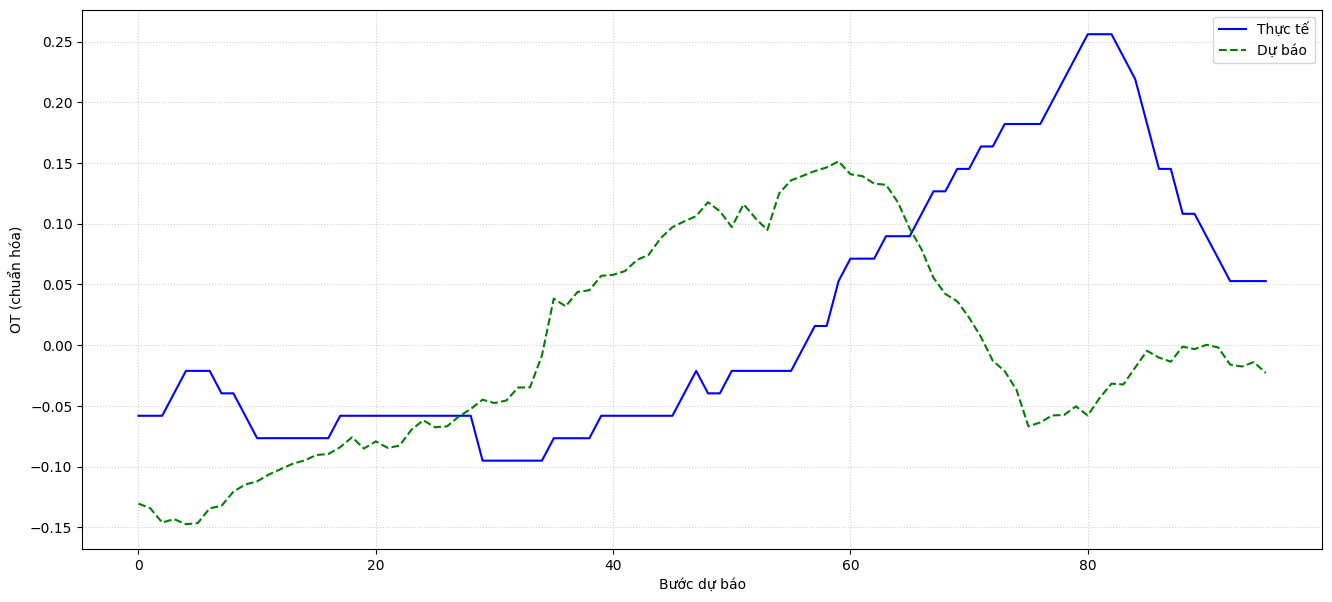

In [196]:
# --- 9. Vẽ Biểu đồ Dự báo Đa bước mẫu ---
print("\n--- 9. Vẽ biểu đồ Dự báo Đa bước (horizon=96, 1 mẫu) ---")
if y_96.shape[0] > 0:
    sample_idx = 0
    plt.figure(figsize=(16, 7))
    plt.plot(y_96[sample_idx], label='Thực tế', color='blue')
    plt.plot(model_96.predict(features_96[sample_idx:sample_idx+1]).flatten(),
             label='Dự báo', color='green', linestyle='--')
    # plt.title('Dự báo Đa bước - Horizon 96')
    plt.xlabel('Bước dự báo')
    plt.ylabel('OT (chuẩn hóa)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()